# Mod 4 Project 

## Import libraries

In [1]:
import pandas as pd 
import numpy as np 
#import statsmodel.api as sm 
import matplotlib 
import matplotlib.pyplot as plt 
from pandas import Series 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
%matplotlib inline
import itertools
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from math import sqrt



## Helper Functions


In [2]:
def pre_process_data(df_name, cat_name):
    df_name = df.loc[df['Category'] == cat_name]
    cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
    df_name.drop(cols, axis = 1, inplace = True)
    df_name = df_name.sort_values('Order Date')
    df_name = df_name.groupby('Order Date')['Sales'].sum().reset_index()
    ## indexing for time series forecasting 
    df_name = df_name.set_index('Order Date')
    return df_name


##plots a line plot or a dot plot depending on the style 
#takes two parameters df_name as dataframe and plot style as the type of plot you want to use, leave empty for line plot and use
# b. for dot plot. 
def line_plot(df_name, plot_style = None ):
    if plot_style == 'dot plot': 
        df_name.plot(figsize = (22,8), style = 'b.' )
        plt.show()
    else: 
        df_name.plot(figsize = (22,8))
        plt.show()

##Time Series Histogram 
def hist_plot(df_name): 
    df_name.hist(figsize = (12,6))
    plt.show()
    
def density_plot(df_name): 
    df_name.plot(kind='kde', figsize = (12,6))
    plt.show() 
    
    
## Grouping And Vizualizing
def group_data(df_name, sub= None): 
    year_groups = df_name.groupby(pd.Grouper(freq = 'A'))
    #Create a new data frame to store yearly values in columns
    temp_annual =pd.DataFrame()
    
    for yr, group in year_groups: 
        temp_annual[yr.year] = group.values.ravel()
    # plot the yearly groups as subplots
    if sub == 'False':
        temp_annual.plot(figsize = (22,15), subplots = False, legend = True)
    else: 
        temp_annual.plot(figsize = (22,15), subplots = True, legend = True)

    plt.show() 
    
    return temp_annual
    
    
##Time Series HeatMap

def heatmap(df_name):
    #transpose the yearly group DataFramn
    year_matrix = df_name.T
    plt.matshow(year_matrix, interpolation=None, aspect='auto', cmap =plt.cm.Spectral_r)
    plt.show

def rolling_stats(df_name): 
    ## Determine rollin statistics 
    roll_mean = df_name.rolling(window=12, center=False).mean()
    roll_std = df_name.rolling(window=12, center=False).std()
    fig = plt.figure(figsize=(12,6))
    plt.plot(furniture, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
def dickey_fuller(df_name):
    dftest = adfuller(df_name)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print ('Results of Dickey-Fuller test: \n')
    print(dfoutput)

## Load Data 

I am using a superstore data

In [3]:
df = pd.read_excel("superstore.xls")

In [4]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## Data exploration and Data Cleaning

In [5]:
df.info() 
df.isnull().sum() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

There are'nt any data missing. and we can see clearly that there are 20 columns. I will have to delete the columns that aren't necessary. I will dive into the categories column to see what I am going to implement

In [6]:
df.groupby(['Category']).first()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Category,,,,,,,,,,,,,,,,,,,,
Furniture,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Bookcases,Bush Somerset Collection Bookcase,261.960,2,0.0,41.9136
Office Supplies,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.0,6.8714
Technology,8,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,TEC-PH-10002275,Phones,Mitel 5320 IP Phone VoIP phone,907.152,6,0.2,90.7152


I will start with Category furniture and move to office supplies finishing at Technology. I will then compare them to each other and see which ones are the best point to start 

As requested by the marketing team in the company, I will look into the furniture dataset first. 

# Furniture 

## Data preprocessing 

In [7]:
furniture = df.loc[df['Category'] == 'Furniture']

Let's Explore the data further

In [8]:
furniture.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 9990
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         2121 non-null   int64         
 1   Order ID       2121 non-null   object        
 2   Order Date     2121 non-null   datetime64[ns]
 3   Ship Date      2121 non-null   datetime64[ns]
 4   Ship Mode      2121 non-null   object        
 5   Customer ID    2121 non-null   object        
 6   Customer Name  2121 non-null   object        
 7   Segment        2121 non-null   object        
 8   Country        2121 non-null   object        
 9   City           2121 non-null   object        
 10  State          2121 non-null   object        
 11  Postal Code    2121 non-null   int64         
 12  Region         2121 non-null   object        
 13  Product ID     2121 non-null   object        
 14  Category       2121 non-null   object        
 15  Sub-Category   2121 n

I will be using Order Date to check how far does the data goes to. 

In [9]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

There's 4 years of data available to make the necessary experimentss 

There are columns that aren't needed at this specific point, I will proceed to delete those now. 

In [10]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis =1, inplace = True)
furniture = furniture.sort_values('Order Date')
furniture.head()

C:\Users\EC\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


There's no need to check if there are any null values as this was checked before and returned a value of 0 on every columna.

The index of the dataset needs to be resetted. 

In [11]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [12]:
furniture

,Order Date,Sales
0,2014-01-06,2573.8200
1,2014-01-07,76.7280
2,2014-01-10,51.9400
3,2014-01-11,9.9400
4,2014-01-13,879.9390
...,...,...
884,2017-12-24,1393.4940
885,2017-12-25,832.4540
886,2017-12-28,551.2568
887,2017-12-29,2330.7180


### Indexing for Time Series Data

The dataset has a normal index, however, the dataset needs to have the date as index. 

In [13]:
furniture = furniture.set_index('Order Date')
furniture.index 

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

I will be forecasting the dataset by months, therefore I will use the average sales value of each month instead. 

In [14]:
y = furniture['Sales'].resample('MS').mean()

In [15]:
y

Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049188
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
2016-01-01     508.182867
2016-02-01     356.868273
2016-03-01     609.575810
2016-04-01     695.373158
2016-05-01     687.265227
2016-06-01     816.910750
2016-07-01     768.736412
2016-08-01     734.307782
2016-09-01    1135.953371
2016-10-01     624.872474
2016-11-01    1271.345152
2016-12-01    1410.719808
2017-01-01     397.602133
2017-02-01     528.179800
2

Let's check that the index has changed correctly, I will be testing using year 2015

In [16]:
y['2015']

Order Date
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
Freq: MS, Name: Sales, dtype: float64

As I will be exploring one more category, and all of the above needs to be done with the respective dataset I will create a function that can be used to get all of this done. 

In [17]:
furniture = furniture['Sales'].resample('MS').mean()

In [18]:
furniture['2015']

Order Date
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
Freq: MS, Name: Sales, dtype: float64

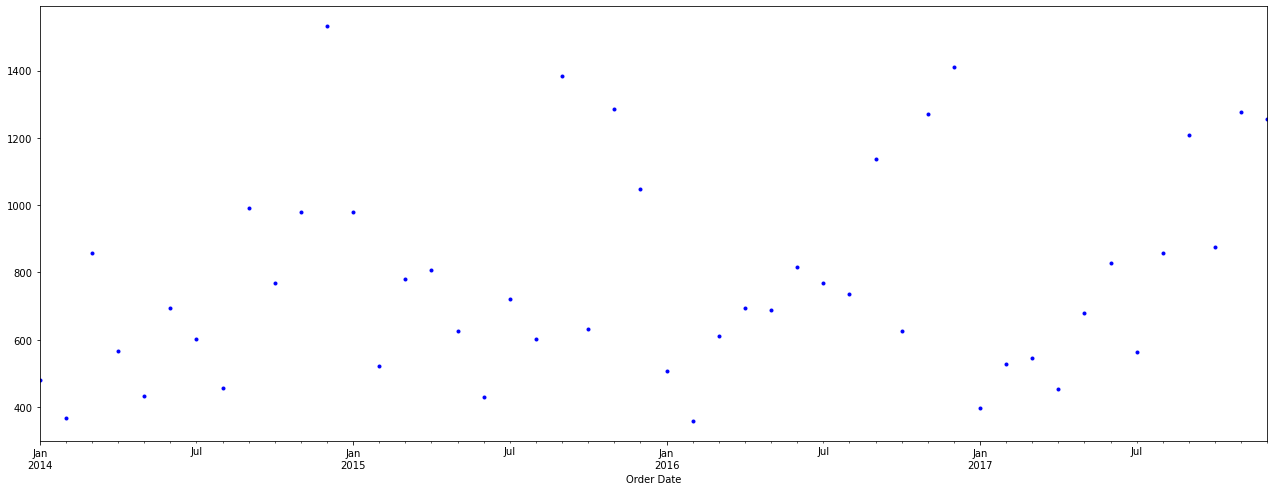

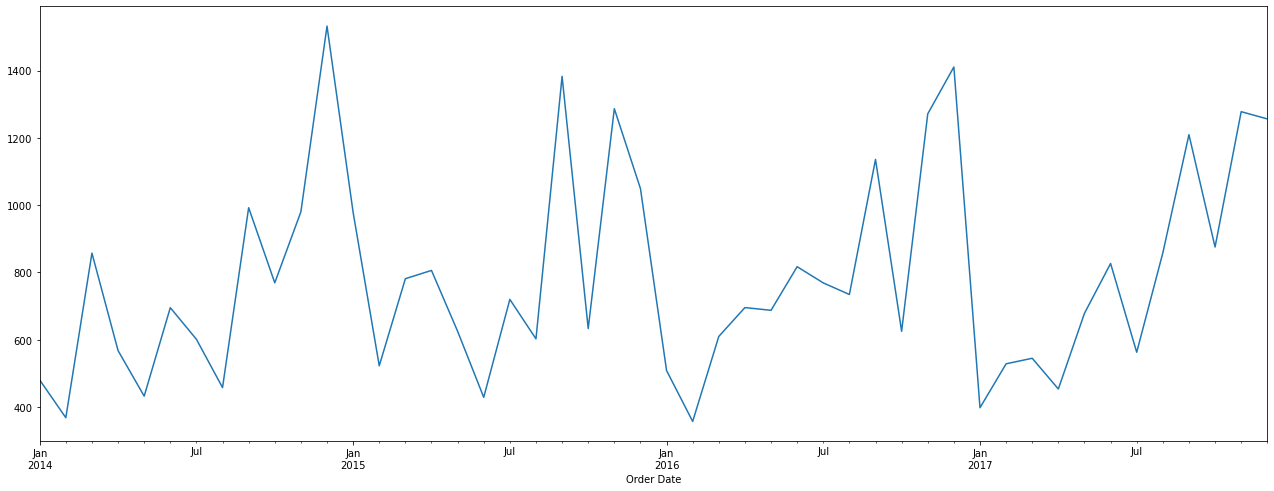

In [19]:
line_plot(furniture, 'dot plot')
line_plot(furniture)

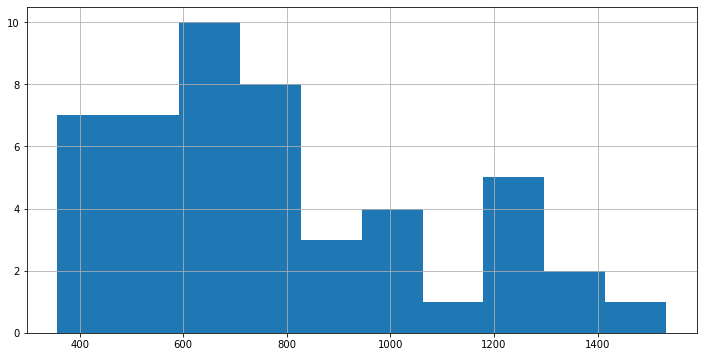

In [20]:
hist_plot(furniture)

We cant appreciate properly if there is a gaussian curve in this histogram. Therefore a density plot might be able to help here. 

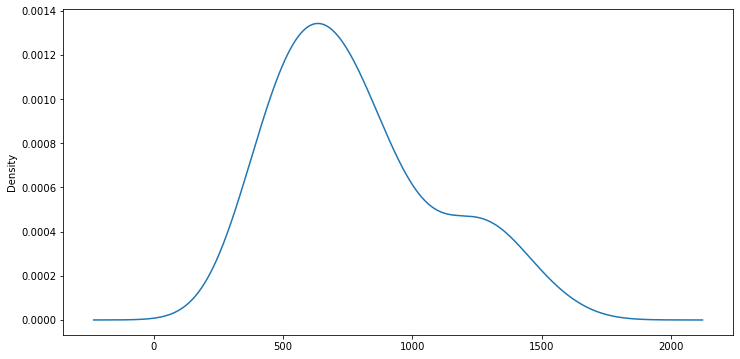

In [21]:
density_plot(furniture)

As expected the density plot shows a more reliable guassian curve. We can say that this data is normally distributed

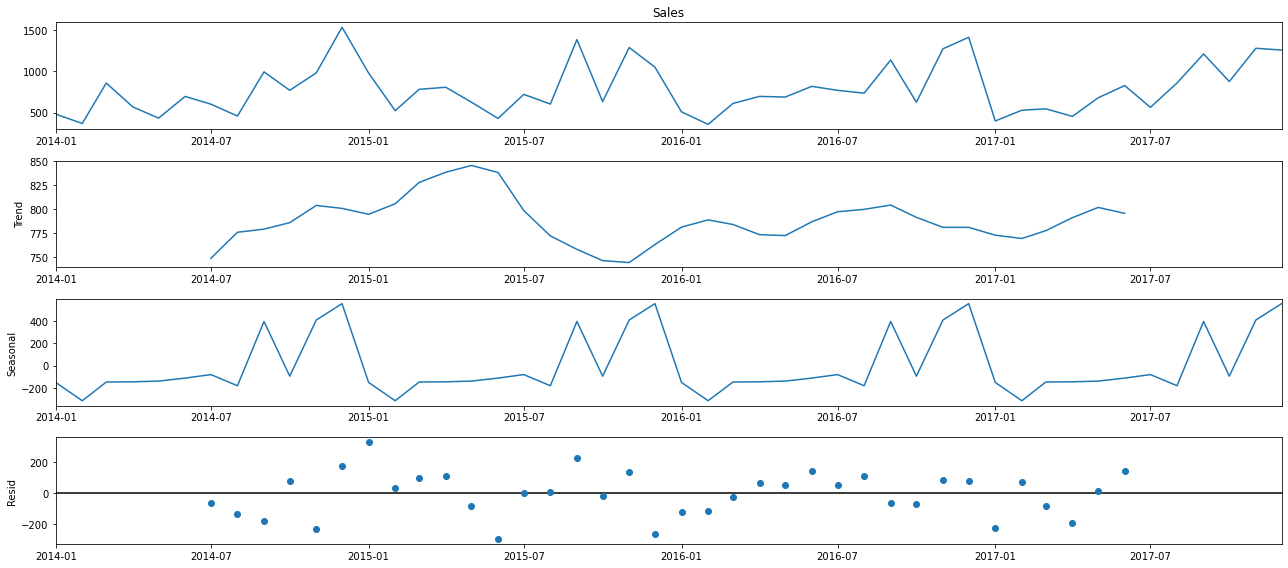

In [22]:
rcParams['figure.figsize']=18,8
decomposition = sm.tsa.seasonal_decompose(furniture, model = 'additive')
fig = decomposition.plot()
plt.show()

It can be appreciated that there is seasonality towards the end of every year as there is an increase in sales. 

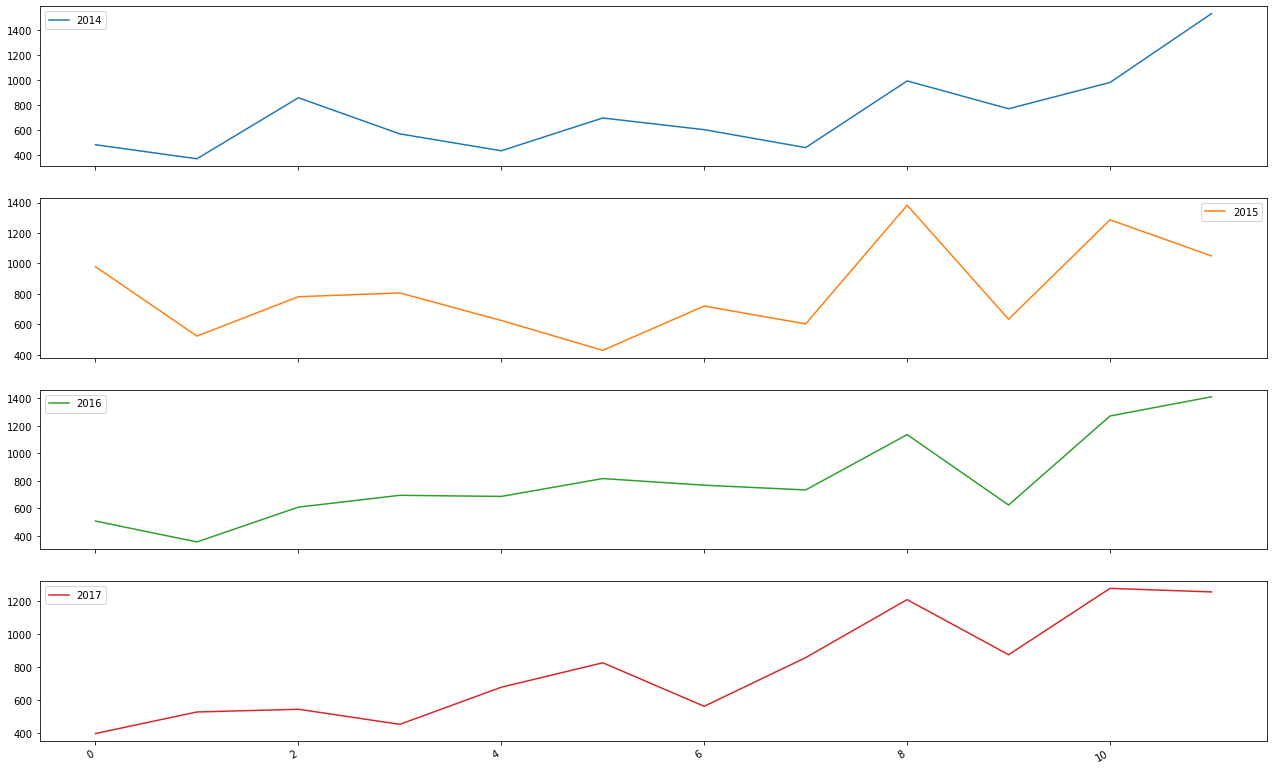

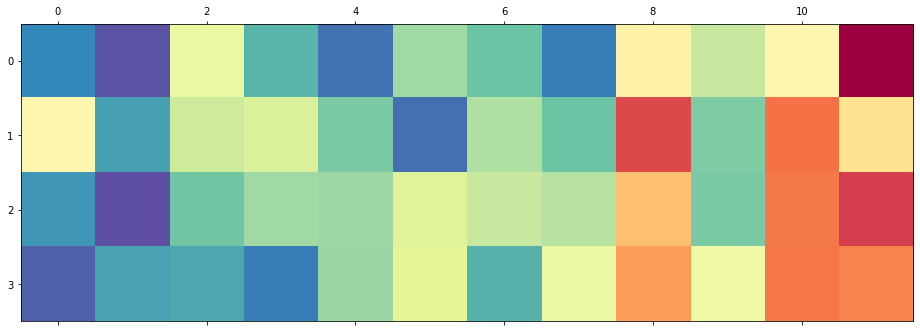

In [24]:
temp_annual = group_data(furniture)
heatmap(temp_annual)

Heatmap and yearly line plot shows that towards the end of the year the sales increase rapidly, specially from month 10 to 12 (October-December. This corroborates with the 4 year line graph.


## Rolling Statistics

Using Rolling statistics, it can be determined if the data is stationary. 

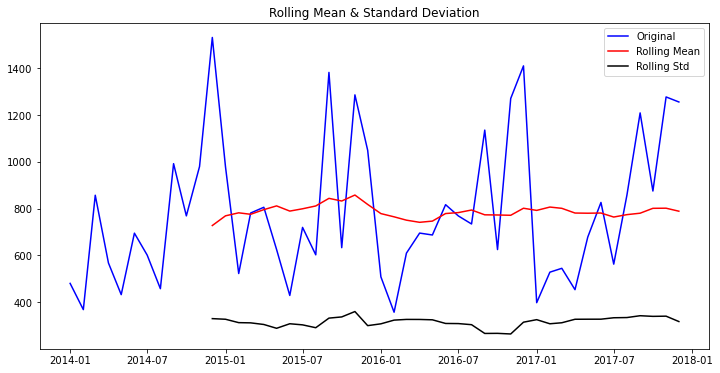

In [25]:
rolling_stats(furniture)

The rolling mean is constant as well as the rolling standard deviation. Therefore, visually the data is stationary. 

## The Dickey-Fuller Test 

Running the Dickey Fuller test will allow to further validate if the data is stationary. The main idea of the Dickey-Fuller test is the null-hypothesis, therefore if the test statistics is less than the 0.5 (p>0.5) then we reject the null hypothesis and say that the series is stationary. 

In [26]:
dickey_fuller(furniture)

Results of Dickey-Fuller test: 

Test Statistic                 -5.191070
p-value                         0.000009
#Lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64



P-value is less 0.05, therefore the null hypthesis is rejected and the series is stationary. 

 ## Autocorrelation and Partial Autocorrelation

ACF shows the correlation of the time series data with its own lagged values. Lag 1 shows the correlation between the original time series data and one lag1, y_t and y_t-1. The shaded area at the autocorrelation points show weak correlation at those lags, therefore they arent consider significant in the analysis.

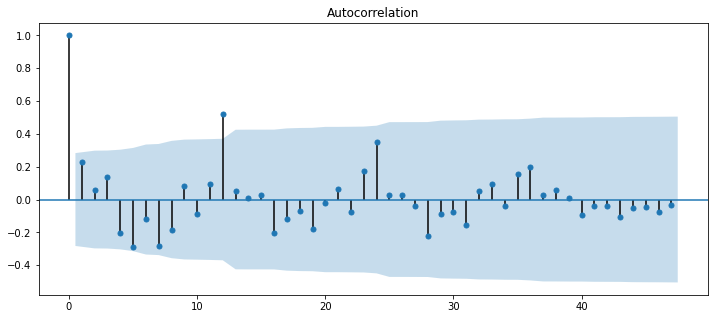

In [27]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(furniture, ax = ax, lags = 47)
plt.show()

PACF shows the correlation in a stationary time series data with its own lagged values. However, PACF removes the correlation contribution of other lags, and gives a clean correlation between two lags without the effect of other lags. 

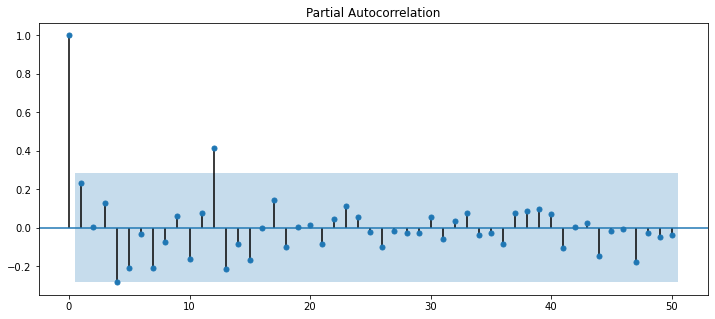

In [28]:
rcParams['figure.figsize']=12,5
plot_pacf(furniture, lags =50, method = 'ywm')
plt.show()

In [29]:
#plt.figure(figsize=(12,5))
#pd.plotting.autocorrelation_plot(furniture)

ACF and PACF is used to determined the correct order for AR(p) and MA(q) components of an ARIMA model. For AR order p, we look at the value of PACF, this value needs to have a significant correlation before correlations become insignificant. 

## ARMA Model 

Now that it has been tested that the data is stationary and that it is also seasonal, as every end of the year the furniture sales go high, It is time to fit the ARIMA Model, However, because it is a seasonal data I have chosen to implement a SARIMAX model 


There's a few things to clarify first, Using autocorrelation and partial autocorrelation I have come to the conclusion of that I am stimating that the values for AR and MA will be between 0 and 1. I will make a gridsearch to find the best possible values for the model using AIC and BIC values as the deciding factor. 

## Splitting the data 

Splitting the data into train and test sets.

In [30]:
furniture.size

48

In [31]:
train = furniture.iloc[:32]
test = furniture.iloc[32:]

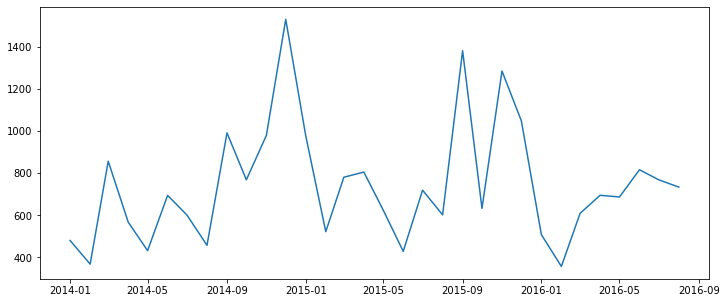

In [32]:
plt.plot(train)

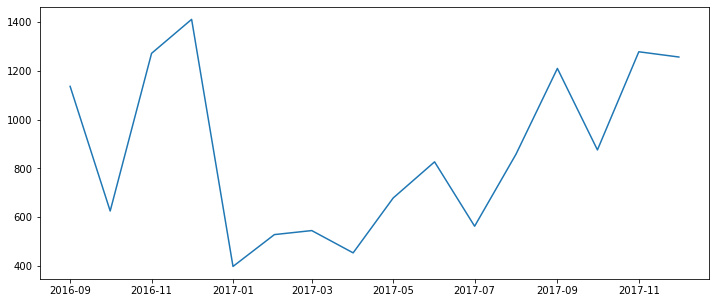

In [33]:
plt.plot(test)

In [34]:

arima_model =  auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=276.957, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=270.974, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=275.324, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=272.827, Time=0.38 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=272.121, Time=0.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=271.826, Time=0.13 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=269.429, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=274.177, Time=0.02 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=270.798, Time=0.68 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=

In [35]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   32
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                -131.714
Date:                             Fri, 05 Mar 2021   AIC                            269.429
Time:                                     00:31:03   BIC                            272.262
Sample:                                          0   HQIC                           269.908
                                              - 32                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9869      3.682     -0.268      0.789      -8.204       6.230
ar.S.L12      -0.8336      0.170     -4.903      0.000      -1.167      -0.500
sigma2      2.622e+04   9.56e+04      0.274      0.784   -1.61e+05    2.14e+05
===================================================================================
Ljung-Box (Q):                       17.95   Jarque-Bera (JB):                 1.54
Prob(Q):                              0.46   Prob(JB):                         0.46
Heteroskedasticity (H):               1.27   Skew:                            -0.05
Prob(H) (two-sided):                  0.78   Kurtosis:                         1.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 16), index=test.index)
prediction.columns = ['sales']
prediction


,sales
Order Date,
2016-09-01,1141.102018
2016-10-01,830.174731
2016-11-01,1115.002118
2016-12-01,1535.742515
2017-01-01,983.901748
2017-02-01,578.648346
2017-03-01,836.468729
2017-04-01,871.238912
2017-05-01,719.147837


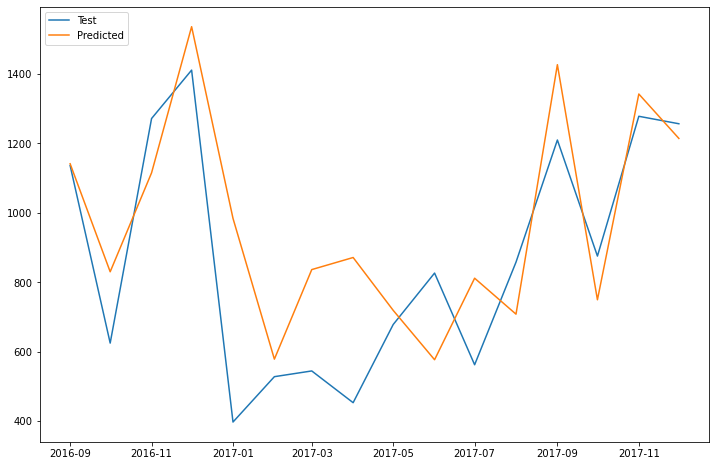

In [40]:
plt.figure(figsize=(12,8))
#plt.plot(train, label='Training')
plt.plot(test,label = 'Test')
plt.plot(prediction, label='Predicted')
plt.legend(loc = 'upper left')
plt.show()

In [41]:
prediction

,sales
Order Date,
2016-09-01,1141.102018
2016-10-01,830.174731
2016-11-01,1115.002118
2016-12-01,1535.742515
2017-01-01,983.901748
2017-02-01,578.648346
2017-03-01,836.468729
2017-04-01,871.238912
2017-05-01,719.147837


In [42]:
test

Order Date
2016-09-01    1135.953371
2016-10-01     624.872474
2016-11-01    1271.345152
2016-12-01    1410.719808
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

In [43]:
prediction['sales']

Order Date
2016-09-01    1141.102018
2016-10-01     830.174731
2016-11-01    1115.002118
2016-12-01    1535.742515
2017-01-01     983.901748
2017-02-01     578.648346
2017-03-01     836.468729
2017-04-01     871.238912
2017-05-01     719.147837
2017-06-01     576.966093
2017-07-01     811.654972
2017-08-01     708.147049
2017-09-01    1426.372396
2017-10-01     749.578993
2017-11-01    1341.927223
2017-12-01    1214.067255
Freq: MS, Name: sales, dtype: float64

In [44]:
sqrt(mean_squared_error(test, prediction['sales']))


237.89579638291252